In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


2025-04-03 16:29:54.552540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_folder = '/Users/ash/Downloads/cancer detection using mamograms/Final Image/new/manifest-1743632552426'
metadata_path = '/Users/ash/Downloads/cancer detection using mamograms/calc_case_description_test_set.csv'
metadata = pd.read_csv(metadata_path)

X_data = []
y_labels = []

for root, _, files in os.walk(image_folder):
    for file in files:
        if file.endswith('.dcm'):
            try:
                dcm_path = os.path.join(root, file)
                ds = pydicom.dcmread(dcm_path)
                img = Image.fromarray(ds.pixel_array).resize((224, 224))
                img_arr = np.array(img).astype('float32') / 255.0
                img_arr = np.expand_dims(img_arr, axis=-1)
                raw_id = ds.PatientID
                patient_id = raw_id.split('_')[0] + '_' + raw_id.split('_')[1]
                matched = metadata[metadata['patient_id'] == patient_id]
                if matched.empty:
                    continue
                label = 1 if matched.iloc[0]['pathology'] == 'MALIGNANT' else 0
                X_data.append(img_arr)
                y_labels.append(label)
            except Exception:
                continue

X_data = np.array(X_data, dtype='float32')
y_labels = np.array(y_labels, dtype='int32')

In [3]:
risk_path = '/Users/ash/Downloads/cancer detection using mamograms/risk factor'
df1 = pd.read_csv(os.path.join(risk_path, 'bcsc_risk_factors_summarized1_092020.csv'))
df2 = pd.read_csv(os.path.join(risk_path, 'bcsc_risk_factors_summarized2_092020.csv'))
df3 = pd.read_csv(os.path.join(risk_path, 'bcsc_risk_factors_summarized3_092020.csv'))
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
selected_columns = ['age_group_5_years', 'first_degree_hx', 'current_hrt', 'menopaus', 'bmi_group', 'BIRADS_breast_density']
clean_df = combined_df[selected_columns].dropna().astype('int32')
lifestyle_input = clean_df.iloc[:len(X_data)].values
print(f"Loaded lifestyle features with shape: {lifestyle_input.shape}")


Loaded lifestyle features with shape: (48, 6)


In [4]:
assert len(X_data) == len(lifestyle_input) == len(y_labels)
X_train_img, X_test_img, X_train_life, X_test_life, y_train, y_test = train_test_split(
    X_data, lifestyle_input, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

print(f"Train samples: {len(X_train_img)}, Test samples: {len(X_test_img)}")


Train samples: 38, Test samples: 10


In [5]:
img_input = Input(shape=(224, 224, 1), name="image_input")
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
life_input = Input(shape=(6,), name="lifestyle_input")
merged = Concatenate()([x, life_input])
z = Dense(128, activation='relu')(merged)
z = Dropout(0.3)(z)
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)
model = Model(inputs=[img_input, life_input], outputs=z)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print("Model successfully compiled")


2025-04-03 16:30:02.685073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model successfully compiled


In [6]:
from sklearn.model_selection import train_test_split

X_train_img, X_test_img, X_train_life, X_test_life, y_train, y_test = train_test_split(
    X_data, lifestyle_input, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

history = model.fit([X_train_img, X_train_life], y_train,
                    validation_data=([X_test_img, X_test_life], y_test),
                    epochs=10, batch_size=8)


Epoch 1/10
5/5 [==============================] - 3s 354ms/step - loss: 17.0103 - accuracy: 0.6842 - val_loss: 47.9477 - val_accuracy: 0.8000
Epoch 2/10
5/5 [==============================] - 2s 308ms/step - loss: 11.7276 - accuracy: 0.8421 - val_loss: 14.7148 - val_accuracy: 0.8000
Epoch 3/10
5/5 [==============================] - 2s 312ms/step - loss: 2.0700 - accuracy: 0.8684 - val_loss: 2.2215 - val_accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 2s 303ms/step - loss: 4.1071 - accuracy: 0.7895 - val_loss: 4.4066 - val_accuracy: 0.7000
Epoch 5/10
5/5 [==============================] - 1s 300ms/step - loss: 4.3957 - accuracy: 0.7368 - val_loss: 11.0141 - val_accuracy: 0.8000
Epoch 6/10
5/5 [==============================] - 2s 303ms/step - loss: 6.0336 - accuracy: 0.8158 - val_loss: 23.9289 - val_accuracy: 0.8000
Epoch 7/10
5/5 [==============================] - 2s 318ms/step - loss: 4.4202 - accuracy: 0.8421 - val_loss: 23.4030 - val_accuracy: 0.8000
Epoch 8/10
5/

In [7]:
from sklearn.model_selection import train_test_split

X_train_img, X_test_img, X_train_life, X_test_life, y_train, y_test = train_test_split(
    X_data, lifestyle_input, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)

history = model.fit(
    [X_train_img, X_train_life], y_train,
    validation_data=([X_test_img, X_test_life], y_test),
    epochs=10,
    batch_size=8
)

print(f"Training complete. epoch accuracy: {history.history['accuracy'][-1]:.4f}")


Epoch 1/10
5/5 [==============================] - 2s 303ms/step - loss: 0.8148 - accuracy: 0.8158 - val_loss: 2.1264 - val_accuracy: 0.8000
Epoch 2/10
5/5 [==============================] - 2s 314ms/step - loss: 2.1652 - accuracy: 0.8421 - val_loss: 9.4343 - val_accuracy: 0.8000
Epoch 3/10
5/5 [==============================] - 2s 319ms/step - loss: 3.4436 - accuracy: 0.8158 - val_loss: 17.9046 - val_accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 2s 309ms/step - loss: 5.2412 - accuracy: 0.8421 - val_loss: 15.3633 - val_accuracy: 0.8000
Epoch 5/10
5/5 [==============================] - 2s 309ms/step - loss: 2.0336 - accuracy: 0.8421 - val_loss: 8.8058 - val_accuracy: 0.8000
Epoch 6/10
5/5 [==============================] - 2s 306ms/step - loss: 0.9791 - accuracy: 0.8684 - val_loss: 4.0914 - val_accuracy: 0.9000
Epoch 7/10
5/5 [==============================] - 2s 307ms/step - loss: 0.2205 - accuracy: 0.8947 - val_loss: 2.6404 - val_accuracy: 0.9000
Epoch 8/10
5/5 [==

In [8]:
risk_data_path = '/Users/ash/Downloads/cancer detection using mamograms/risk factor'

df1 = pd.read_csv(os.path.join(risk_data_path, 'bcsc_risk_factors_summarized1_092020.csv'))
df2 = pd.read_csv(os.path.join(risk_data_path, 'bcsc_risk_factors_summarized2_092020.csv'))
df3 = pd.read_csv(os.path.join(risk_data_path, 'bcsc_risk_factors_summarized3_092020.csv'))

bcsc_full_df = pd.concat([df1, df2, df3], ignore_index=True)

selected_cols = [
    'age_group_5_years',
    'first_degree_hx',
    'current_hrt',
    'menopaus',
    'bmi_group',
    'BIRADS_breast_density'
]

risk_features = bcsc_full_df[selected_cols].dropna().astype('int32')

print(f"Risk feature matrix shape: {risk_features.shape}")


Risk feature matrix shape: (1522340, 6)


In [9]:
X_data = np.array(X_data, dtype='float32')
y_labels = np.array([1 if y == 1 else 0 for y in y_labels], dtype='int32')
lifestyle_input = risk_features.iloc[:len(X_data)].values

X_train_img, X_test_img, X_train_life, X_test_life, y_train, y_test = train_test_split(
    X_data, lifestyle_input, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

img_input = Input(shape=(224, 224, 1))
life_input = Input(shape=(6,))

x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

merged = Concatenate()([x, life_input])
z = Dense(64, activation='relu')(merged)
z = Dropout(0.3)(z)
z = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[img_input, life_input], outputs=z)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    [X_train_img, X_train_life], y_train,
    validation_data=([X_test_img, X_test_life], y_test),
    epochs=10,
    batch_size=8
)

model.save('mammogram_cnn_multimodal_model.h5')


Epoch 1/10
5/5 [==============================] - 2s 258ms/step - loss: 9.6266 - accuracy: 0.7632 - val_loss: 65.1736 - val_accuracy: 0.8000
Epoch 2/10
5/5 [==============================] - 1s 229ms/step - loss: 16.3475 - accuracy: 0.8421 - val_loss: 36.5115 - val_accuracy: 0.8000
Epoch 3/10
5/5 [==============================] - 1s 227ms/step - loss: 8.0008 - accuracy: 0.8421 - val_loss: 5.9990 - val_accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 1s 227ms/step - loss: 3.3745 - accuracy: 0.7632 - val_loss: 2.3188 - val_accuracy: 0.7000
Epoch 5/10
5/5 [==============================] - 1s 228ms/step - loss: 3.8493 - accuracy: 0.7632 - val_loss: 3.0367 - val_accuracy: 0.8000
Epoch 6/10
5/5 [==============================] - 1s 233ms/step - loss: 1.7878 - accuracy: 0.8158 - val_loss: 8.0418 - val_accuracy: 0.8000
Epoch 7/10
5/5 [==============================] - 1s 226ms/step - loss: 1.7733 - accuracy: 0.8421 - val_loss: 7.0477 - val_accuracy: 0.8000
Epoch 8/10
5/5 [=

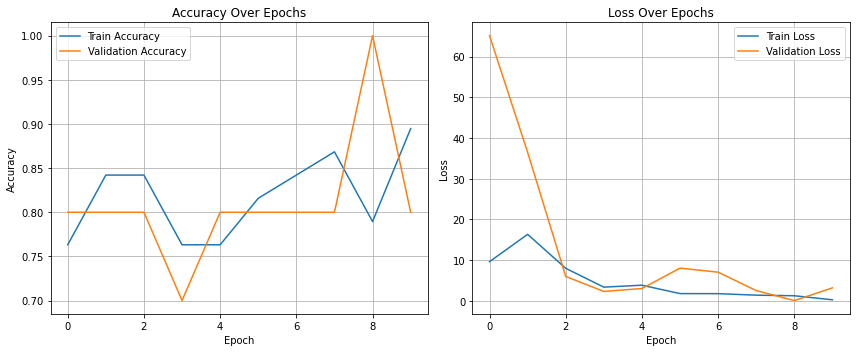

In [10]:


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
import shap

explainer = shap.GradientExplainer(
    model,
    data=[X_train_img[:50], X_train_life[:50]]
)
print("SHAP GradientExplainer ready.")


SHAP GradientExplainer ready.


/Users/ash/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


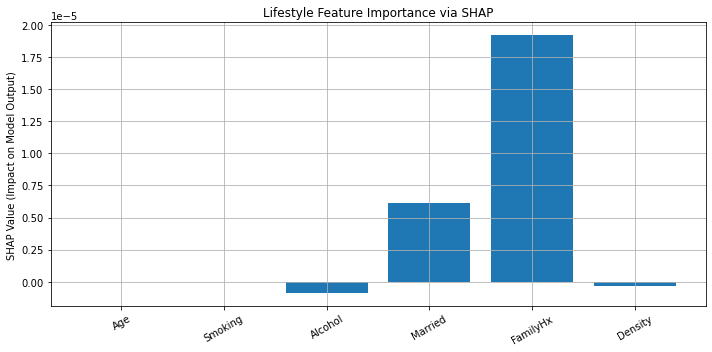

In [12]:
sample_idx = 0
img_input = X_test_img[sample_idx:sample_idx+1]
life_input = X_test_life[sample_idx:sample_idx+1]

shap_values = explainer.shap_values([img_input, life_input])

feature_names = ["Age", "Smoking", "Alcohol", "Married", "FamilyHx", "Density"]
life_shap = shap_values[1][0].flatten()

plt.figure(figsize=(10, 5))
plt.bar(feature_names, life_shap)
plt.title("Lifestyle Feature Importance via SHAP")
plt.ylabel("SHAP Value (Impact on Model Output)")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

def generate_pdf_report(user_data, result, confidence, shap_values, feature_names):
    try:
        print("🔄 Generating PDF...")
        filename = f"{user_data['first_name']}_{user_data['last_name']}_report.pdf"
        c = canvas.Canvas(filename, pagesize=A4)

        # Header
        c.setFont("Helvetica-Bold", 18)
        c.drawString(50, 800, "🩺 Personalized Breast Cancer Risk Report")

        # Patient Info
        c.setFont("Helvetica", 12)
        c.drawString(50, 770, f"Name: {user_data['first_name']} {user_data['last_name']}")
        c.drawString(50, 750, f"Email: {user_data['email']}")
        c.drawString(50, 730, f"Date of Birth: {user_data['dob']} (Age: {user_data['age']})")
        c.drawString(50, 710, f"Marital Status: {user_data['marital_status']}")
        c.drawString(50, 690, f"Drug History: {', '.join(user_data['drugs'])}")
        
        # Prediction result
        c.setFont("Helvetica-Bold", 14)
        c.drawString(50, 660, f"Prediction: {result}")
        c.drawString(50, 640, f"Confidence: {confidence}%")

        # SHAP values
        c.setFont("Helvetica-Bold", 12)
        c.drawString(50, 610, "Top Lifestyle Risk Factors (SHAP Importance):")

        if shap_values is not None:
            sorted_factors = sorted(zip(feature_names, shap_values), key=lambda x: abs(x[1]), reverse=True)
            for i, (feature, value) in enumerate(sorted_factors[:5]):
                c.drawString(70, 590 - i*20, f"{feature}: {round(value, 3)}")
        else:
            c.drawString(70, 590, "SHAP values not available.")

        # Disclaimer
        c.setFont("Helvetica", 10)
        c.drawString(50, 470, "⚠️ This is an AI-generated assessment. Clinical validation is required.")
        c.save()

        print(f"✅ PDF saved as: {filename}")
    except Exception as e:
        print(f"❌ Error during PDF generation: {e}")


In [14]:
import os
import numpy as np
import pydicom
from PIL import Image
from datetime import datetime
from tkinter import Tk, Label, Entry, Button, filedialog, StringVar, OptionMenu, messagebox
from fuzzywuzzy import process
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
import shap
from tensorflow.keras.models import load_model


selected_mammograms = []
model = load_model("mammogram_cnn_multimodal_model.h5")
explainer = shap.GradientExplainer(model, [np.zeros((1, 224, 224, 1)), np.zeros((1, 6))])
def correct_multiple_drugs(drug_input):
    known_terms = ["smoking", "alcohol", "none"]
    return list(set([
        process.extractOne(d.strip().lower(), known_terms)[0] for d in drug_input.split(',') if d.strip()
    ]))
def select_mammograms():
    global selected_mammograms
    selected_mammograms = filedialog.askopenfilenames(filetypes=[("DICOM files", "*.dcm")])
    if selected_mammograms:
        status_label.config(text=f"🖼️ {len(selected_mammograms)} mammogram(s) selected.")
        print(f"🖼️ Selected {len(selected_mammograms)} mammograms.")
    else:
        selected_mammograms = []
        status_label.config(text="No .DICOM files selected.")
def generate_pdf_report(user_data, result, confidence, shap_values, feature_names):
    filename = filedialog.asksaveasfilename(
        defaultextension=".pdf",
        filetypes=[("PDF files", "*.pdf")],
        initialfile=f"{user_data['first_name']}_{user_data['last_name']}_report.pdf"
    )
    if not filename:
        return

    c = canvas.Canvas(filename, pagesize=A4)
    c.setFont("Helvetica-Bold", 18)
    c.drawString(50, 800, "Personalized Breast Cancer Risk Report")

    c.setFont("Helvetica", 12)
    c.drawString(50, 770, f"Name: {user_data['first_name']} {user_data['last_name']}")
    c.drawString(50, 755, f"Email: {user_data['email']}")
    c.drawString(50, 740, f"Date of Birth: {user_data['dob']} (Age: {user_data['age']})")
    c.drawString(50, 725, f"Marital Status: {user_data['marital_status']}")
    c.drawString(50, 710, f"Drug History: {', '.join(user_data['drugs'])}")
    c.drawString(50, 695, f"Family History: {user_data['family_history']}")
    c.drawString(50, 675, f"Prediction: {result}")
    c.drawString(50, 660, f"Confidence: {confidence}%")

    c.drawString(50, 630, "Top Risk Factors (SHAP Importance):")
    sorted_features = sorted(zip(feature_names, shap_values), key=lambda x: abs(x[1]), reverse=True)
    for idx, (feat, val) in enumerate(sorted_features[:5]):
        c.drawString(70, 610 - (idx * 20), f"{feat}: {round(float(val), 3)}")

    c.drawString(50, 500, "Future Risk Projections (Assumed):")
    for future_age in [30, 40, 50, 60]:
        risk_score = min(100, round(confidence + (future_age - user_data['age']) * 0.5, 2))
        c.drawString(70, 480 - (future_age // 10 * 10), f"At age {future_age}: estimated risk {risk_score}%")

    c.drawString(50, 400, "Disclaimer: This AI model is a tool, not a definitive diagnosis. Please consult a physician.")
    c.save()
    messagebox.showinfo("Report Generated", f"Report successfully saved to: {filename}")
    status_label.config(text="Report successfully generated!")
def on_generate():
    if not selected_mammograms:
        messagebox.showerror("No File", "Please select at least one DICOM file.")
        return

    first_name = entries["First Name"].get()
    last_name = entries["Last Name"].get()
    email = entries["Email"].get()
    dob_input = entries["Date of Birth (YYYY-MM-DD)"].get()
    drugs = correct_multiple_drugs(entries["Drug History"].get())
    marital_status = marital_var.get()
    family_history = family_var.get()

    try:
        age = (datetime.today() - datetime.strptime(dob_input, "%Y-%m-%d")).days // 365
    except ValueError:
        messagebox.showerror("Invalid Date", "Use YYYY-MM-DD format for date of birth.")
        return

    
    img_arrays = []
    for dicom_path in selected_mammograms:
        ds = pydicom.dcmread(dicom_path)
        img = Image.fromarray(ds.pixel_array).resize((224, 224))
        img_arr = np.array(img) / 255.0
        img_arr = np.expand_dims(img_arr.astype('float32'), axis=-1)  # shape: (224, 224, 1)
        img_arrays.append(img_arr)

    if not img_arrays:
        messagebox.showerror("Image Error", "Could not process any mammogram images.")
        return

    avg_img = np.mean(img_arrays, axis=0)
    avg_img = np.expand_dims(avg_img, axis=0)  # shape: (1, 224, 224, 1)

    lifestyle_arr = np.array([[
        age,
        int("smoking" in drugs),
        int("alcohol" in drugs),
        int(marital_status.lower() == "married"),
        int(any(f in family_history.lower() for f in ["mother", "sister", "grandmother"])),
        2
    ]], dtype='float32')

    try:
        pred = model.predict([avg_img, lifestyle_arr])[0][0]
        result = "Malignant" if pred > 0.5 else "Benign"
        confidence = round(pred * 100 if result == "Malignant" else (1 - pred) * 100, 2)
        shap_vals = explainer.shap_values([avg_img, lifestyle_arr])[1][0]

        user_data = {
            "first_name": first_name,
            "last_name": last_name,
            "email": email,
            "dob": dob_input,
            "age": age,
            "drugs": drugs,
            "marital_status": marital_status,
            "family_history": family_history
        }

        generate_pdf_report(user_data, result, confidence, shap_vals, ["Age", "Smoking", "Alcohol", "Married", "FamilyHx", "Density"])
    except Exception as e:
        messagebox.showerror("Prediction Error", f"Something went wrong during prediction.\n\n{str(e)}")
        return


root = Tk()
root.title("Breast Cancer AI Report Generator")
root.geometry("440x600")

entries = {}
fields = ["First Name", "Last Name", "Email", "Date of Birth (YYYY-MM-DD)", "Drug History"]
for label in fields:
    Label(root, text=label).pack()
    entry = Entry(root)
    entry.pack()
    entries[label] = entry

Label(root, text="Marital Status").pack()
marital_var = StringVar(root)
marital_var.set("Single")
OptionMenu(root, marital_var, "Single", "Married").pack()

Label(root, text="Family History").pack()
family_var = StringVar(root)
family_var.set("None")
OptionMenu(root, family_var, "None", "Mother had", "Grandmother had", "Sister had", "Multiple family members").pack()

Button(root, text="🖼 Select Mammograms", command=select_mammograms, bg="blue", fg="Green").pack(pady=10)
Button(root, text="📄 Generate Report", command=on_generate, bg="green", fg="Green").pack(pady=20)

status_label = Label(root, text="")
status_label.pack()

root.mainloop()

🖼️ Selected 2 mammograms.
1/1 [==============================] - 0s 92ms/step


2025-04-03 16:35:01.247 python[80209:2509573] Warning: Expected min height of view: (<NSButton: 0x7fec7c86b9f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
